In [2]:
# setup
# file
import os

# Data Processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

# model
import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# explain
import seaborn as sns
import shap


# folder
folder_input = '02_input'

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# import data
# original data
org = pd.read_csv(os.path.join('..', folder_input, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))

# check any missing value
org.isnull().sum()


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
# data cleansing

# target (turn to bool)
cleaned_data = org.copy()
cleaned_data['Churn'] = cleaned_data['Churn'] == "Yes"

# total charges - " " to 0
cleaned_data['TotalCharges'] = cleaned_data['TotalCharges'].str.replace(" ", "0", case=False, regex=False)
cleaned_data = cleaned_data.astype({'TotalCharges': 'float64'})

# drop useless cols
cleaned_data = cleaned_data.drop(
    labels=['customerID'],
    axis=1
)

# cleaned_data.head()

In [5]:
# train vs test
# seperate target from predictors
X = cleaned_data.copy()            # use copy, not to affect original dataset
y = X.pop('Churn')        # y = "churn", and delete churn from X

# train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [6]:
# preprocessing for categorical data
cleaned_data.info()

# select categorical columns
# PS: [categorical_cols] mean == True
categorical_cols = X_train.dtypes == 'object'
categorical_cols = list(categorical_cols[categorical_cols].index)  
categorical_cols    

# one hot encoder
# PS: The one hot encoder output is a series, need to turn to dataframe
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(X_test[categorical_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# add back colnames
OH_cols_train.columns = OH_encoder.get_feature_names_out()
OH_cols_test.columns = OH_encoder.get_feature_names_out()


# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(categorical_cols, axis=1)
num_X_test = X_test.drop(categorical_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
X_test = pd.concat([num_X_test, OH_cols_test], axis=1)


X_train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3296,0,24,49.30,1233.25,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6397,1,54,65.25,3529.95,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6043,0,3,40.15,130.75,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5309,0,61,20.25,1278.80,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3000,0,12,84.45,1059.55,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [7]:
# preprocessing for numerical data
# select numericial columns
numericial_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# scaler
num_encoder = StandardScaler()
num_cols_train = pd.DataFrame(num_encoder.fit_transform(X_train[numericial_cols]))
num_cols_test = pd.DataFrame(num_encoder.fit_transform(X_test[numericial_cols]))

# One-hot encoding removed index; put it back
num_cols_train.index = X_train.index
num_cols_test.index = X_test.index

# add back colnames
num_cols_train.columns = num_encoder.get_feature_names_out()
num_cols_test.columns = num_encoder.get_feature_names_out()

# Remove numerical  columns (will replace with encoding)
cat_X_train = X_train.drop(numericial_cols, axis=1)
cat_X_test = X_test.drop(numericial_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train = pd.concat([cat_X_train, num_cols_train], axis=1)
X_test = pd.concat([cat_X_test, num_cols_test], axis=1)




In [28]:
# define model
# ie structure of the neural network

tf.random.set_seed(0)

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=50, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# model
tf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape = [45]),   # non-linear
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),      # classification
])

# Outstanding: Add dropout and batch normalization (ref: kaggle learn; https://www.kaggle.com/code/ryanholbrook/dropout-and-batch-normalization/tutorial)

In [29]:
# model compile
# tell model what to adjust to  

tf_model.compile(
    loss = tf.keras.losses.binary_crossentropy,                   # for classification
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),         # what else to show in each epoch
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

In [30]:
# fit model 
history = tf_model.fit(
    X_train, 
    y_train,
    validation_data=[X_test, y_test], 
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping]
    )

Epoch 1/500
21/21 [==============================] - 2s 27ms/step - loss: 0.4581 - accuracy: 0.7885 - precision: 0.6312 - recall: 0.4943 - val_loss: 0.4464 - val_accuracy: 0.7899 - val_precision: 0.6069 - val_recall: 0.5702
Epoch 2/500
21/21 [==============================] - 0s 5ms/step - loss: 0.4188 - accuracy: 0.8050 - precision: 0.6652 - recall: 0.5384 - val_loss: 0.4422 - val_accuracy: 0.7905 - val_precision: 0.6088 - val_recall: 0.5680
Epoch 3/500
21/21 [==============================] - 0s 6ms/step - loss: 0.4147 - accuracy: 0.8073 - precision: 0.6726 - recall: 0.5377 - val_loss: 0.4406 - val_accuracy: 0.7956 - val_precision: 0.6200 - val_recall: 0.5745
Epoch 4/500
21/21 [==============================] - 0s 7ms/step - loss: 0.4144 - accuracy: 0.8059 - precision: 0.6635 - recall: 0.5498 - val_loss: 0.4401 - val_accuracy: 0.7933 - val_precision: 0.6523 - val_recall: 0.4579
Epoch 5/500
21/21 [==============================] - 0s 6ms/step - loss: 0.4151 - accuracy: 0.8039 - precis

In [31]:
# epoch_used: for plotting on graph
epoch_used = len(history.history['loss'])+1      # python has to add 1 for order in the list
epoch_used

71

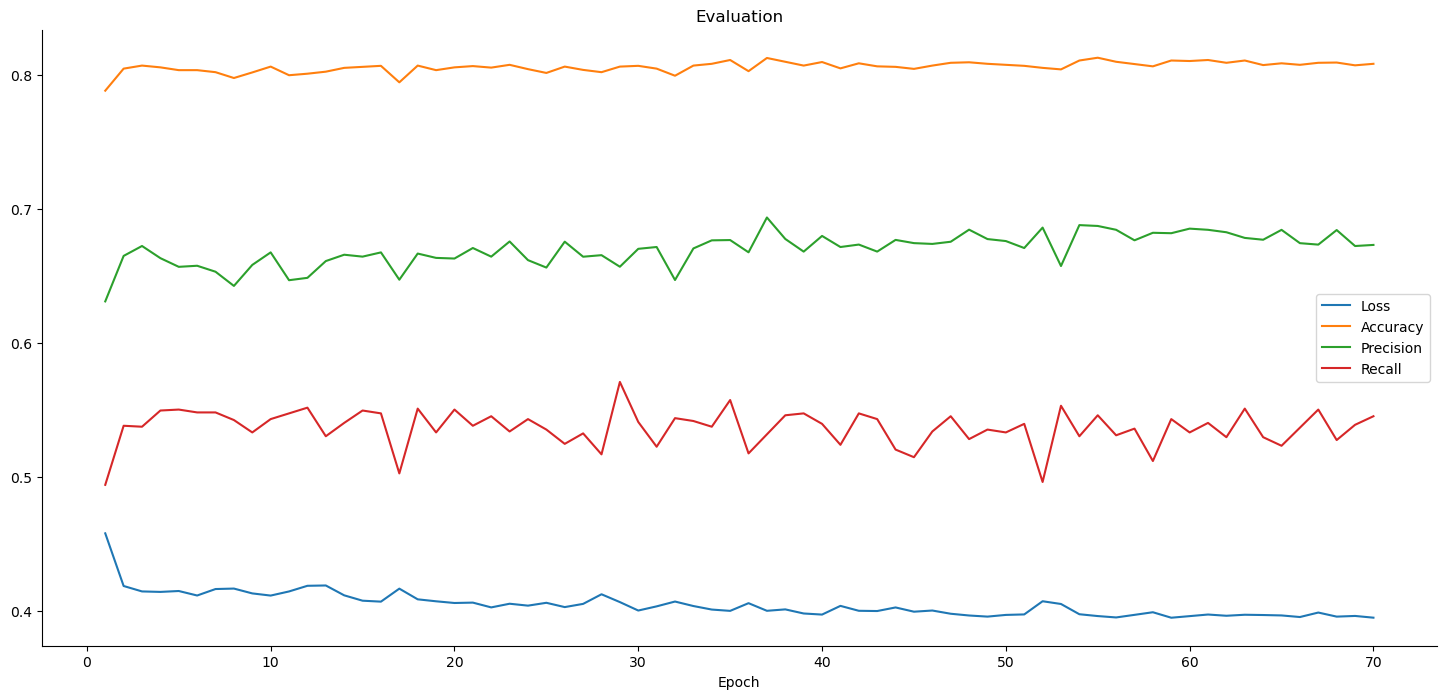

In [32]:
# set up matplotlib for model evaluation

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (18,8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

# plot
plt.plot(np.arange(1, epoch_used), history.history['loss'], label='Loss')
plt.plot(np.arange(1, epoch_used), history.history['accuracy'], label='Accuracy')
plt.plot(np.arange(1, epoch_used), history.history['precision'], label='Precision')
plt.plot(np.arange(1, epoch_used), history.history['recall'], label='Recall')
plt.title('Evaluation')
plt.xlabel('Epoch')
plt.legend()

In [33]:
# prediction
# tf will output probailty instead of 1, 0
preds = tf_model.predict(X_test)

# turn preds into bool
# PS: if probabily >= 0.5, then True
preds_bool = preds >= 0.5


56/56 [==============================] - 0s 2ms/step


In [34]:
# evaluation
accuracy_score(y_test, preds_bool)

0.7932992617830777

In [35]:
# confusion matrix
confusion_matrix(y_test, preds_bool)

array([[1182,  116],
       [ 248,  215]], dtype=int64)

In [36]:
# classification report
print(classification_report(y_test, preds_bool))

              precision    recall  f1-score   support

       False       0.83      0.91      0.87      1298
        True       0.65      0.46      0.54       463

    accuracy                           0.79      1761
   macro avg       0.74      0.69      0.70      1761
weighted avg       0.78      0.79      0.78      1761



In [1]:
# need to use shap for feature importance
# TBC